In [2]:
import matplotlib.pyplot as plt
from matplotlib import mlab
import numpy as np
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio
import sklearn
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

alphabet = ''.join(chr(ord("A") + i) for i in range(26))

In [74]:
def load_dataset(downsample=5):
    letters = np.empty((4, 26, 20), dtype=object)
    for i, j, k in np.ndindex(letters.shape):
        subject = i + 1
        letter = alphabet[j]
        fs, x = scipy.io.wavfile.read(f"letters/{subject}/{letter}/PZ/{k}.wav")
        letters[i, j, k] = x # scipy.signal.decimate(x, downsample)
    # Assumes all letters have same sample rate.
    return letters, fs # / downsample

In [70]:
def filter_transients(x, n):
    return np.min(x[:len(x)//n*n].reshape((-1, n)), axis=1)

In [75]:
letters, fs = load_dataset()

In [80]:
def find_strokes(x, fs, verbose=False):
    X, freqs, t = mlab.specgram(x, Fs=fs, NFFT=512, noverlap=256)
    summed = np.sum(X[15:30], axis=0)
#     summed = np.sum(np.log(X[15:30] + 1e-6), axis=0)
#     summed = np.log(np.sum(X[15:30], axis=0))
    summed -= np.min(summed)
    filtered = filter_transients(summed, 3)
    smoothed = np.convolve(filtered, np.ones(6))
    smoothed /= np.max(smoothed)

    peaks, info = scipy.signal.find_peaks(smoothed, height=0.2, prominence=0.15, distance=10)
    amp = info["peak_heights"]

    if verbose:
        # plt.plot(summed[::3] / np.max(summed))
        # plt.plot(filtered / np.max(filtered))
        plt.plot(smoothed)
        plt.scatter(peaks, amp, c='red')
        plt.show()

#     active = smoothed > 0.3
#     indices = np.where(active)[0]
#     new_runs = np.where(np.diff(indices) > 1)[0]
#     starts = indices[np.hstack(([0], new_runs + 1))]
#     ends = indices[np.hstack((new_runs, [-1]))]

#     times = starts.astype(float)
    times = peaks.astype(float)
    times -= times[0]
#     widths = (ends - starts).astype(float)
    if len(times) > 1:
#         widths /= times[-1]
        times /= times[-1]
#     amp = np.empty(len(times))
#     for i, (start, end) in enumerate(zip(starts, ends)):
#         amp[i] = smoothed[start:end+1].mean()
    amp = info["peak_heights"]  

    # Matrix of [[stroke time, stroke duration, stroke amplitude]]
    return np.vstack((times, amp)).T

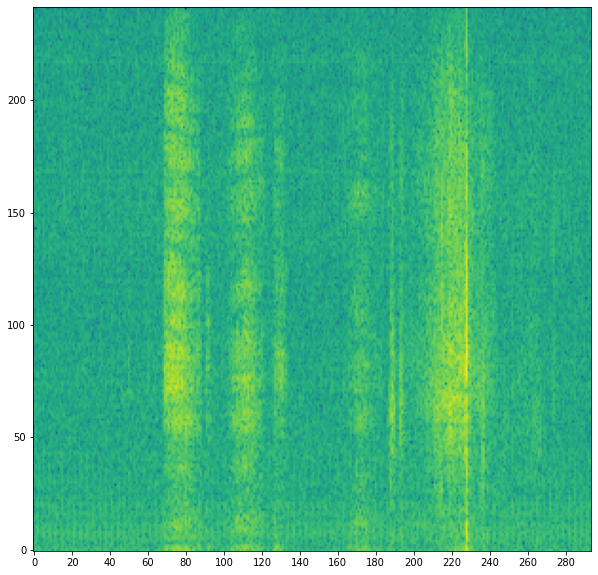

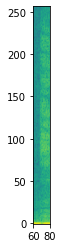

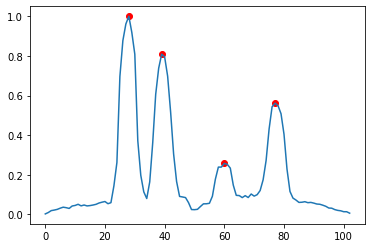

In [116]:
x = letters[1,0,0]
display(Audio(x, rate=fs))
plt.figure(figsize=(10,10))
X, t, f = mlab.specgram(x, NFFT=512, noverlap=256)
plt.imshow(np.log(X)[15:], origin='lower', aspect='auto')
plt.xticks(np.arange(0, X.shape[1], 20))
plt.show()
plt.imshow(np.log(X), origin='lower')
plt.xlim(60,80)
# plt.xlim(225, 235)
plt.show()
find_strokes(x, fs, verbose=True)
# X = np.log(X)
# m = X.mean(axis=1)[:, None]
# s = X.std(axis=1)[:, None]
# X -= m
# X /= s
X = np.log(X)
# plt.imshow(X, origin='lower')
# plt.show()

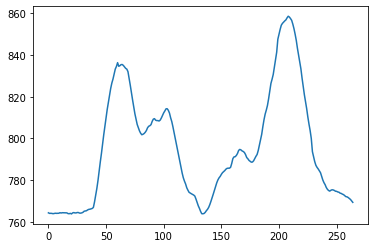

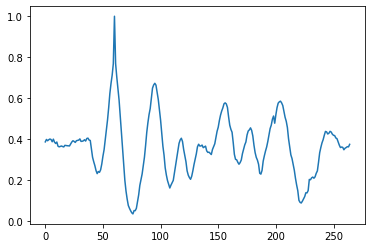

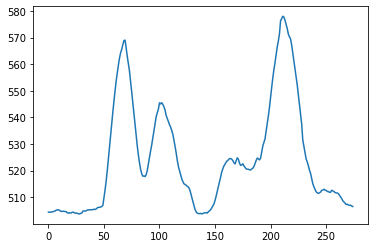

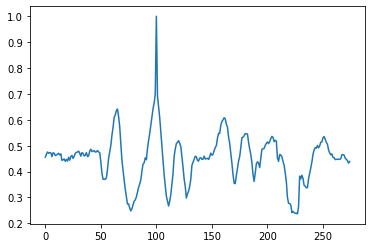

(257, 294) (257, 30)


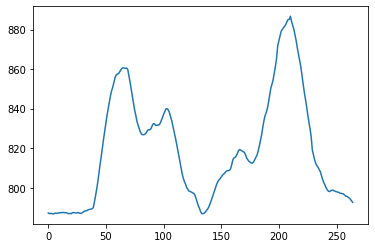

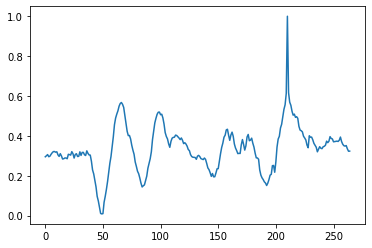

In [117]:
from skimage.feature import match_template

stroke_noise = X[:, 60:90]
corr = scipy.signal.correlate(X, stroke_noise, mode='valid')[0] / stroke_noise.size
plt.plot(corr); plt.show()
result = match_template(X, stroke_noise)[0]
plt.plot(result); plt.show()

stroke_noise2 = X[:, 100:120]
corr = scipy.signal.correlate(X, stroke_noise2, mode='valid')[0] / stroke_noise.size
plt.plot(corr); plt.show()
result = match_template(X, stroke_noise2)[0]
plt.plot(result); plt.show()

paper_noise = X[:, 210:240]
print(X.shape, paper_noise.shape)
corr = scipy.signal.correlate(X, paper_noise, mode='valid')[0] / paper_noise.size
plt.plot(corr); plt.show()
result = match_template(X, paper_noise)[0]
plt.plot(result)

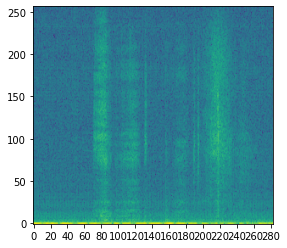

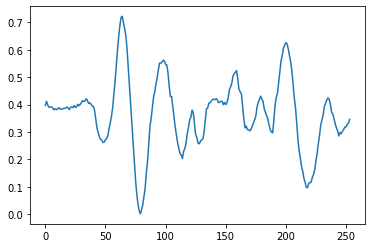

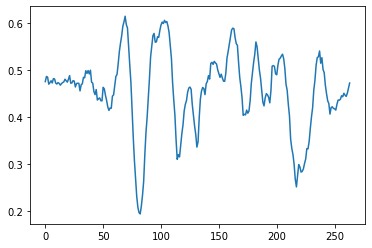

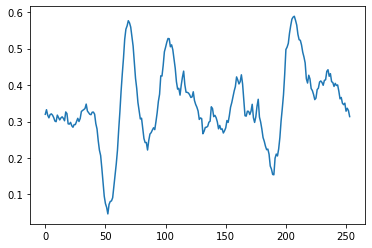

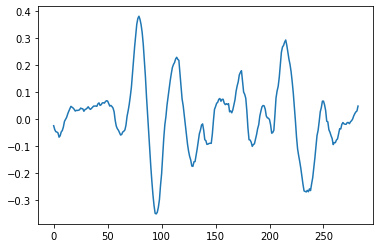

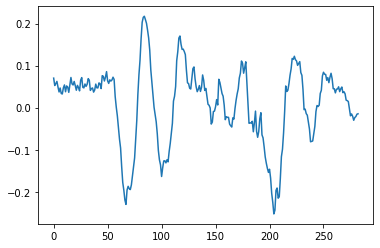

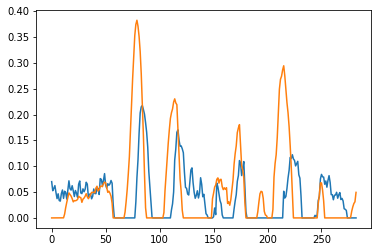

In [141]:
x = letters[1,0,1]
display(Audio(x, rate=fs))
X, t, f = mlab.specgram(x, NFFT=512, noverlap=256)
plt.imshow(np.log(X), origin='lower')
plt.xticks(np.arange(0, X.shape[1], 20))
plt.show()

# X -= m
# X /= s
X = np.log(X)

plt.plot(match_template(X, stroke_noise)[0]); plt.show()
plt.plot(match_template(X, stroke_noise2)[0]); plt.show()
plt.plot(match_template(X, paper_noise)[0]); plt.show()
sn = match_template(X, stroke_noise, pad_input=True, mode='median')[0]
pn = match_template(X, paper_noise, pad_input=True, mode='median')[0]
plt.plot(sn); plt.show()
plt.plot(pn); plt.show()
# plt.plot((pn - sn))
s = np.sum(X[15:], axis=0)
s -= np.median(s)
plt.plot(np.maximum(pn, 0))
plt.plot(np.maximum(sn, 0))

In [137]:
def process_dataset(letters, fs):
    strokes = np.empty(letters.shape, dtype=object)
    for i in np.ndindex(letters.shape):
        strokes[i] = find_strokes(letters[i], fs)
    return strokes

def pad_strokes(strokes):
    max_strokes = len(max(strokes, key=len))
    features = strokes[0].shape[1]
    stroke_matrix = np.empty(strokes.shape + (max_strokes, features))
    for i, stroke in np.ndenumerate(strokes):
        # extension = np.ones((max_strokes - len(stroke), features)) * 1000
        extension = np.array([stroke[-1]] * (max_strokes - len(stroke))).reshape(-1, features)
        stroke_matrix[i] = np.vstack((stroke, extension))
    return stroke_matrix.reshape((-1, max_strokes * features))

def eval_accuracy(classifier, test, train):
    testY = np.indices(test.shape[:3])[1].reshape(-1)
    trainY = np.indices(train.shape[:3])[1].reshape(-1)
    test = test.reshape(-1)
    train = train.reshape(-1)
    padded = pad_strokes(np.hstack((test, train)))
    testX, trainX = padded[:len(test)], padded[len(test):]
    classifier.fit(trainX, trainY)
    predictY = classifier.predict(testX)
    return np.mean(testY == predictY)

def run(classifier):
    letters, fs = load_dataset()
    strokes = process_dataset(letters, fs)
    test = strokes[:, :, 15:]
    train = strokes[:, :, :15]
    print(f"With all subjects in training data: {round(eval_accuracy(classifier, test, train) * 100, 2)}%")
    for subject in range(len(strokes)):
        test = strokes[subject][None]
        train = np.vstack((strokes[:subject], strokes[subject+1:]))
        print(f"Subject {subject}: {round(eval_accuracy(classifier, test, train) * 100, 2)}%")

In [138]:
run(KNeighborsClassifier(1))

With all subjects in training data: 9.81%
Subject 0: 10.0%
Subject 1: 10.96%
Subject 2: 10.77%
Subject 3: 8.46%


In [192]:
run(svm.SVC())

With all subjects in training data: 7.31%
Subject 0: 4.23%
Subject 1: 5.0%
Subject 2: 7.5%
Subject 3: 6.54%


In [89]:
run(RandomForestClassifier())

With all subjects in training data: 24.81%
Subject 0: 9.23%
Subject 1: 10.19%
Subject 2: 14.04%
Subject 3: 7.12%


In [182]:
run(MLPClassifier(hidden_layer_sizes=(26,26,26,26), max_iter=1000))

With all subjects in training data: 23.65%
Subject 0: 14.23%
Subject 1: 14.42%
Subject 2: 16.73%
Subject 3: 8.08%


(257, 377) float64


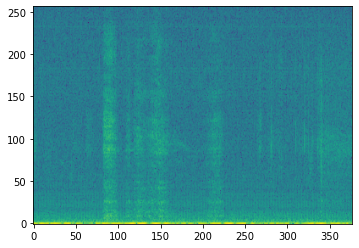

In [156]:
x = letters[1, 17, 16]
display(Audio(x, rate=fs))
X, t, f = mlab.specgram(x, Fs=fs, NFFT=512, noverlap=256)
print(X.shape, X.dtype)
plt.imshow(np.log(X), origin='lower')